In [1]:
import io, os, sys, types

In [2]:
import nbformat

from IPython import get_ipython
from IPython.core.interactiveshell import InteractiveShell

In [3]:
def find_notebook(fullname, path=None):
    """find a notebook, given its fully qualified name and an optional path
    """
    name = fullname.rsplit('.', 1)[-1]
    if not path:
        path = ['']
    for d in path:
        nb_path = os.path.join(d, name + ".ipynb")
        if os.path.isfile(nb_path):
            return nb_path
        # let import Notebook_Name find "Notebook Name.ipynb"
        nb_path = nb_path.replace("_", " ")
        if os.path.isfile(nb_path):
            return nb_path
        

In [4]:
class NotebookLoader(object):
    """Module Loader for IPython Notebooks"""
    def __init__(self, path=None):
        self.shell = InteractiveShell.instance()
        self.path = path
    
    def load_module(self, fullname):
        """import a notebook as a module"""
        path = find_notebook(fullname, self.path)
        
        print ("importing notebook from %s" % path)
                                       
        # load the notebook object
        nb = nbformat.read(path, as_version=4)
        
        
        # create the module and add it to sys.modules
        # if name in sys.modules:
        #    return sys.modules[name]
        mod = types.ModuleType(fullname)
        mod.__file__ = path
        mod.__loader__ = self
        mod.__dict__['get_ipython'] = get_ipython
        sys.modules[fullname] = mod
        
        # extra work to ensure that magics that would affect the user_ns
        # actually affect the notebook module's ns
        save_user_ns = self.shell.user_ns
        self.shell.user_ns = mod.__dict__
        
        try:
          for cell in nb.cells:
            if cell.cell_type == 'code':
                # transform the input to executable Python
                code = self.shell.input_transformer_manager.transform_cell(cell.source)
                # run the code in themodule
                exec(code, mod.__dict__)
        finally:
            self.shell.user_ns = save_user_ns
        return mod

In [5]:
class NotebookFinder(object):
    """Module finder that locates IPython Notebooks"""
    def __init__(self):
        self.loaders = {}
    
    def find_module(self, fullname, path=None):
        nb_path = find_notebook(fullname, path)
        if not nb_path:
            return
        
        key = path
        if path:
            # lists aren't hashable
            key = os.path.sep.join(path)
        
        if key not in self.loaders:
            self.loaders[key] = NotebookLoader(path)
        return self.loaders[key]

In [6]:
sys.meta_path.append(NotebookFinder())

In [7]:
ls

HCgraph.ipynb      Tests.ipynb       Untitled3.ipynb  Untitled.ipynb
SEIDRonGrid.ipynb  two_models.ipynb  Untitled4.ipynb
seir-epidemic.gif  Untitled1.ipynb   Untitled5.ipynb
SEIRonGrid.ipynb   Untitled2.ipynb   Untitled7.ipynb


importing notebook from two_models.ipynb


/cs/home/tt24/.local/lib/python2.7/site-packages/matplotlib/__init__.py:872: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


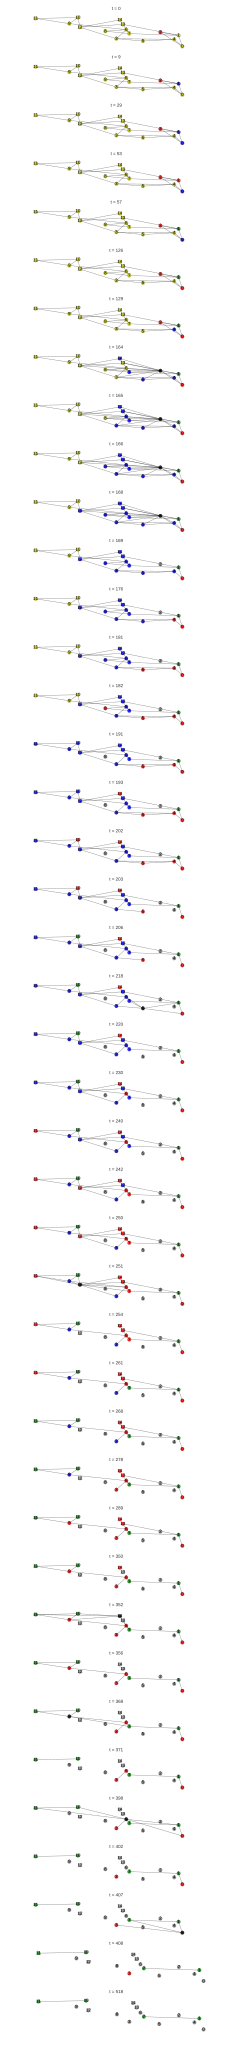

In [8]:
import two_models as model

In [9]:
import unittest

class TestSEIR(unittest.TestCase):
    
    def setUp(self):
        G = model.HCgraph(5, 5, 5)
        self.syn = model.SEIRSynchronousDynamics(pInfected = 0.1, beta = 0.02, gamma = 0.01, eta = 0.008,
                             g = G)
        self.syn.before()
        
    def test_consistency(self):
        for repeat in range(0,100):
            t = 0
            while True:
                # run a step
                nev = self.syn._dynamics_step(t)
                self.assertFalse(set(self.syn._infected) & set(self.syn._exposed))

                # test for termination
                if self.syn.at_equilibrium(t):
                    break

                t = t + 1
            
    def test_consistency2(self):
        for repeat in range(0,100):
            t = 0
            while True:
                # run a step
                nev = self.syn._dynamics_step(t)
                for n in self.syn.nodes():
                    if n in self.syn._infected:
                        self.assertTrue(self.syn.node[n][self.syn.DYNAMICAL_STATE] == self.syn.INFECTED)
                    else:
                        if n in self.syn._exposed: 
                            self.assertTrue(self.syn.node[n][self.syn.DYNAMICAL_STATE] == self.syn.EXPOSED)
                        else:
                            self.assertTrue((self.syn.node[n][self.syn.DYNAMICAL_STATE] == self.syn.SUSCEPTIBLE) or 
                                           (self.syn.node[n][self.syn.DYNAMICAL_STATE] == self.syn.RECOVERED))
                # test for termination
                if self.syn.at_equilibrium(t):
                    break

                t = t + 1
            
    def test_unexpected_states(self):
        for repeat in range(0,100):
            t = 0
            once_infected = {}
            once_exposed = {}
            once_recovered = {}
            while True:
                # run a step
                nev = self.syn._dynamics_step(t)
                once_infected = set(once_infected).union(set(self.syn._infected))
                once_exposed = set(once_exposed).union(set(self.syn._exposed))
                once_recovered =set(once_recovered).union({ n for n in self.syn.nodes() 
                                                           if self.syn.node[n][self.syn.DYNAMICAL_STATE] == self.syn.RECOVERED})
                for n in once_recovered:
                    self.assertTrue((self.syn.node[n][self.syn.DYNAMICAL_STATE] != self.syn.SUSCEPTIBLE) and
                                    (self.syn.node[n][self.syn.DYNAMICAL_STATE] != self.syn.EXPOSED) and 
                                   (self.syn.node[n][self.syn.DYNAMICAL_STATE] != self.syn.INFECTED))
                for n in once_infected:
                    self.assertTrue((self.syn.node[n][self.syn.DYNAMICAL_STATE] != self.syn.SUSCEPTIBLE) and
                                    (self.syn.node[n][self.syn.DYNAMICAL_STATE] != self.syn.EXPOSED))

                for n in once_exposed:
                    self.assertTrue(self.syn.node[n][self.syn.DYNAMICAL_STATE] != self.syn.SUSCEPTIBLE)
                # test for termination
                if self.syn.at_equilibrium(t):
                    break

                t = t + 1

if __name__ == '__main__':
    suite = unittest.TestLoader().loadTestsFromTestCase(TestSEIR)
    unittest.TextTestRunner(verbosity=2).run(suite)

test_consistency (__main__.TestSEIR) ... ok
test_consistency2 (__main__.TestSEIR) ... ok
test_unexpected_states (__main__.TestSEIR) ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.586s

OK


In [10]:
class TestSEIDR(unittest.TestCase):
    
    def setUp(self):
        G = model.HCgraph(5, 5, 5)
        delta = 0.5
        epsilon = 0.3
        zeta = 0.4
        self.syn = model.SEIDRSynchronousDynamics(pInfected = 0.1, beta = 0.02, gamma = 0.01, eta = 0.008, 
                                                  delta =delta, epsilon = epsilon, zeta = zeta,
                             g = G)
        self.syn.before()
        
    def test_consistency(self):
        for repeat in range(0,100):
            t = 0
            while True:
                # run a step
                nev = self.syn._dynamics_step(t)
                self.assertFalse(set(self.syn._infected) & set(self.syn._exposed) & set(self.syn._dead))

                # test for termination
                if self.syn.at_equilibrium(t):
                    break

                t = t + 1
            
    def test_consistency2(self):
        for repeat in range(0,100):
            t = 0
            while True:
                # run a step
                nev = self.syn._dynamics_step(t)
                for n in self.syn.nodes():
                    if n in self.syn._infected:
                        self.assertTrue(self.syn.node[n][self.syn.DYNAMICAL_STATE] == self.syn.INFECTED)
                    else:
                        if n in self.syn._exposed: 
                            self.assertTrue(self.syn.node[n][self.syn.DYNAMICAL_STATE] == self.syn.EXPOSED)
                        else:
                            if n in self.syn._dead: 
                                self.assertTrue(self.syn.node[n][self.syn.DYNAMICAL_STATE] == self.syn.DEAD)
                            else:
                                self.assertTrue((self.syn.node[n][self.syn.DYNAMICAL_STATE] == self.syn.SUSCEPTIBLE) or 
                                               (self.syn.node[n][self.syn.DYNAMICAL_STATE] == self.syn.RECOVERED) or 
                                               (self.syn.node[n][self.syn.DYNAMICAL_STATE] == self.syn.REMOVED))
                # test for termination
                if self.syn.at_equilibrium(t):
                    break

                t = t + 1
            
    def test_unexpected_states(self):
        for repeat in range(0,100):
            t = 0
            once_infected = {}
            once_exposed = {}
            once_recovered = {}
            once_dead = {}
            once_removed = {}
            while True:
                # run a step
                nev = self.syn._dynamics_step(t)
                once_infected = set(once_infected).union(set(self.syn._infected))
                once_exposed = set(once_exposed).union(set(self.syn._exposed))
                once_dead = set(once_dead).union(set(self.syn._dead))
                once_recovered =set(once_recovered).union({ n for n in self.syn.nodes() 
                                                           if self.syn.node[n][self.syn.DYNAMICAL_STATE] == self.syn.RECOVERED})
                once_removed = set(once_removed).union({ n for n in self.syn.nodes() 
                                                        if self.syn.node[n][self.syn.DYNAMICAL_STATE] == self.syn.REMOVED})
                for n in once_recovered:
                    self.assertTrue((self.syn.node[n][self.syn.DYNAMICAL_STATE] != self.syn.SUSCEPTIBLE) and
                                    (self.syn.node[n][self.syn.DYNAMICAL_STATE] != self.syn.EXPOSED) and 
                                   (self.syn.node[n][self.syn.DYNAMICAL_STATE] != self.syn.INFECTED))

                for n in once_removed:
                    self.assertTrue((self.syn.node[n][self.syn.DYNAMICAL_STATE] != self.syn.SUSCEPTIBLE) and
                                    (self.syn.node[n][self.syn.DYNAMICAL_STATE] != self.syn.EXPOSED) and 
                                   (self.syn.node[n][self.syn.DYNAMICAL_STATE] != self.syn.INFECTED))
                for n in once_dead:
                    self.assertTrue((self.syn.node[n][self.syn.DYNAMICAL_STATE] != self.syn.SUSCEPTIBLE) and
                                    (self.syn.node[n][self.syn.DYNAMICAL_STATE] != self.syn.EXPOSED) and 
                                   (self.syn.node[n][self.syn.DYNAMICAL_STATE] != self.syn.INFECTED))
                for n in once_infected:
                    self.assertTrue((self.syn.node[n][self.syn.DYNAMICAL_STATE] != self.syn.SUSCEPTIBLE) and
                                    (self.syn.node[n][self.syn.DYNAMICAL_STATE] != self.syn.EXPOSED))

                for n in once_exposed:
                    self.assertTrue(self.syn.node[n][self.syn.DYNAMICAL_STATE] != self.syn.SUSCEPTIBLE)
                # test for termination
                if self.syn.at_equilibrium(t):
                    break

                t = t + 1

if __name__ == '__main__':
    suite = unittest.TestLoader().loadTestsFromTestCase(TestSEIDR)
    unittest.TextTestRunner(verbosity=2).run(suite)

test_consistency (__main__.TestSEIDR) ... ok
test_consistency2 (__main__.TestSEIDR) ... ok
test_unexpected_states (__main__.TestSEIDR) ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.633s

OK


In [11]:
class TestEdges(unittest.TestCase):
    
    def setUp(self):
        delta = 0.5
        epsilon = 0.3
        zeta = 0.4
        household_size =3
        community_size = 3
        number_of_communities = 2
        self.syn = model.SEIDRSynchronousDynamics(household_size, community_size, number_of_communities, pInfected = 0.1,
                                                  beta = 0.02, gamma = 0.01, eta = 0.008, 
                                                  delta =delta, epsilon = epsilon, zeta = zeta)
        self.syn.before()
        
    def test_infection_spread(self):
        for repeat in range(0,100):
            t = 0
            previous_exposed = []
            while True:
                nev = self.syn._dynamics_step(t)
                if t!= 0:
                    difference = set(self.syn._exposed)-set(previous_exposed)-set(self.syn._infected)-set(self.syn._dead)-set(previous_infected)-set(previous_dead)
    #                 print self.syn._exposed, previous_exposed,previous_infected,previous_dead, self.syn._infected,self.syn._dead, difference
                    for n in difference:
                        infectiousNeighbour = False
                        for (_, m, data) in self.syn.edges_iter(n, data = True):
                            if (self.syn.node[m][self.syn.DYNAMICAL_STATE] == self.syn.INFECTED) or (self.syn.node[m][self.syn.DYNAMICAL_STATE] == self.syn.DEAD) or m in previous_infected or m in previous_dead:
                                infectiousNeighbour = True
                        if (infectiousNeighbour or len(difference)==0):
                            self.assertTrue(True)
                        else:
                            neighbours = []
                            for (_, m, data) in self.syn.edges_iter(n, data = True):
                                neighbours.insert(0, m)
    #                         print n, neighbours
                            self.assertTrue(False)

                previous_exposed = list(self.syn._exposed)
                previous_infected = list(self.syn._infected)
                previous_dead = list(self.syn._dead)
    #             print t
                # test for termination
                if self.syn.at_equilibrium(t):
                    break

                t = t + 1
            
    def test_repeats_in_edges(self):
        t = 0
        while True:
            # run a step
            nev = self.syn._dynamics_step(t)
            self.assertTrue(len(self.syn.edges())==len(set(self.syn.edges())))
            for e in self.syn.edges():
                self.assertFalse((e[1],e[0]) in self.syn.edges())
            # test for termination
            if self.syn.at_equilibrium(t):
                break
            
            t = t + 1
            
    def test_unexpected_states(self):
        t = 0
        once_infected = {}
        once_exposed = {}
        once_recovered = {}
        once_dead = {}
        once_removed = {}
        while True:
            # run a step
            nev = self.syn._dynamics_step(t)
            once_infected = set(once_infected).union(set(self.syn._infected))
            once_exposed = set(once_exposed).union(set(self.syn._exposed))
            once_dead = set(once_dead).union(set(self.syn._dead))
            once_recovered =set(once_recovered).union({ n for n in self.syn.nodes() 
                                                       if self.syn.node[n][self.syn.DYNAMICAL_STATE] == self.syn.RECOVERED})
            once_removed = set(once_removed).union({ n for n in self.syn.nodes() 
                                                    if self.syn.node[n][self.syn.DYNAMICAL_STATE] == self.syn.REMOVED})
            for n in once_recovered:
                self.assertTrue((self.syn.node[n][self.syn.DYNAMICAL_STATE] != self.syn.SUSCEPTIBLE) and
                                (self.syn.node[n][self.syn.DYNAMICAL_STATE] != self.syn.EXPOSED) and 
                               (self.syn.node[n][self.syn.DYNAMICAL_STATE] != self.syn.INFECTED))

            for n in once_removed:
                self.assertTrue((self.syn.node[n][self.syn.DYNAMICAL_STATE] != self.syn.SUSCEPTIBLE) and
                                (self.syn.node[n][self.syn.DYNAMICAL_STATE] != self.syn.EXPOSED) and 
                               (self.syn.node[n][self.syn.DYNAMICAL_STATE] != self.syn.INFECTED))
            for n in once_dead:
                self.assertTrue((self.syn.node[n][self.syn.DYNAMICAL_STATE] != self.syn.SUSCEPTIBLE) and
                                (self.syn.node[n][self.syn.DYNAMICAL_STATE] != self.syn.EXPOSED) and 
                               (self.syn.node[n][self.syn.DYNAMICAL_STATE] != self.syn.INFECTED))
            for n in once_infected:
                self.assertTrue((self.syn.node[n][self.syn.DYNAMICAL_STATE] != self.syn.SUSCEPTIBLE) and
                                (self.syn.node[n][self.syn.DYNAMICAL_STATE] != self.syn.EXPOSED))
                
            for n in once_exposed:
                self.assertTrue(self.syn.node[n][self.syn.DYNAMICAL_STATE] != self.syn.SUSCEPTIBLE)
            # test for termination
            if self.syn.at_equilibrium(t):
                break
                
            t = t + 1

if __name__ == '__main__':
    suite = unittest.TestLoader().loadTestsFromTestCase(TestEdges)
    unittest.TextTestRunner(verbosity=2).run(suite)

test_infection_spread (__main__.TestEdges) ... ok
test_repeats_in_edges (__main__.TestEdges) ... ok
test_unexpected_states (__main__.TestEdges) ... ok

----------------------------------------------------------------------
Ran 3 tests in 0.833s

OK


In [12]:
household_size =3
community_size = 3
number_of_communities = 2
gamma = 0.01
beta = 0.02
delta = 0.5
epsilon = 0.3
zeta = 0.4
eta = 0.008
syn = model.SEIDRSynchronousDynamics(household_size, community_size, number_of_communities, pInfected = 0.1,
                              beta = beta, gamma = gamma, eta = eta, delta = delta, epsilon = epsilon, zeta = zeta)
syn_dyn = syn.dynamics()

NetworkXError: Node 104 has no position.

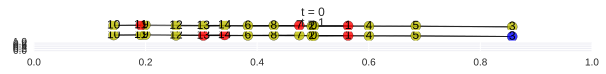

In [13]:
model.show_changes(syn, syn_dyn)